In [1]:
import argparse
import time
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from dataset.datasets import PFLDDatasets

# from models.mobilev3_pfld import PFLDInference

cudnn.benchmark = True
cudnn.determinstic = True
cudnn.enabled = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Re-importing the necessary libraries
from torch.utils.data import Dataset
from PIL import Image

class PFLDSingleImageDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        img = Image.open(self.img_path)
        # Convert the image to RGB format to ensure it only has three channels
        img = img.convert("RGB")
        # Resize the image to 112x112 before applying other transformations
        img = img.resize((112, 112), Image.BILINEAR)
        if self.transform:
            img = self.transform(img)
        
        # Assume that the ground truth is not known in this case
        landmark_gt = torch.zeros(106, 2)
        attribute = torch.zeros(6)
        
        return img, landmark_gt, attribute

# Now, when you create a PFLDSingleImageDataset, it will automatically convert the image to RGB and resize it to 112x112.


In [12]:
# Function to compute Non-Maximum Suppression Error (NME)
def compute_nme(preds, target):
    N = preds.shape[0]
    L = preds.shape[1]
    rmse = np.zeros(N)
    

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 19:  # aflw
            interocular = 34
        elif L == 29:  # cofw
            interocular = np.linalg.norm(pts_gt[8, ] - pts_gt[9, ])
        elif L == 68:  # 300w
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        elif L == 98:
            interocular = np.linalg.norm(pts_gt[60, ] - pts_gt[72, ])
        elif L == 106:
            interocular = np.linalg.norm(pts_gt[35, ] - pts_gt[93, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt, axis=1)) / interocular
    print("@", N, L, rmse)  
    return rmse

# Function to compute Area Under Curve (AUC)
def compute_auc(errors, failureThreshold, step=0.0001, showCurve=False):
    nErrors = len(errors)
    xAxis = list(np.arange(0., failureThreshold + step, step))
    ced = [float(np.count_nonzero([errors <= x])) / nErrors for x in xAxis]

    AUC = simps(ced, x=xAxis) / failureThreshold
    failureRate = 1. - ced[-1]

    if showCurve:
        plt.plot(xAxis, ced)
        plt.show()

    return AUC, failureRate 

In [13]:
# Validation function
def validate(wlfw_val_dataloader, plfd_backbone, show_image=False):
    plfd_backbone.eval()

    nme_list = []
    cost_time = []
    with torch.no_grad():
        for img, landmark_gt, _ in wlfw_val_dataloader:
            img = img.to(device)
            landmark_gt = landmark_gt.to(device)
            plfd_backbone = plfd_backbone.to(device)

            start_time = time.time()
            _, landmarks = plfd_backbone(img)
            cost_time.append(time.time() - start_time)

            landmarks = landmarks.cpu().numpy()
            landmarks = landmarks.reshape(landmarks.shape[0], -1, 2)  # landmark
            landmark_gt = landmark_gt.reshape(landmark_gt.shape[0], -1, 2).cpu().numpy()  # landmark_gt

            if show_image:
                show_img = np.array(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
                show_img = (show_img * 255).astype(np.uint8)
                np.clip(show_img, 0, 255)

                pre_landmark = landmarks[0] * [112, 112]

                cv2.imwrite("xxx.jpg", show_img)
                img_clone = cv2.imread("xxx.jpg")

                for (x, y) in pre_landmark.astype(np.int32):
                    cv2.circle(img_clone, (x, y), 1, (255, 0, 0),-1)
                cv2.imshow("xx.jpg", img_clone)
                cv2.waitKey(0)

            nme_temp = compute_nme(landmarks, landmark_gt)
            for item in nme_temp:
                nme_list.append(item)

        print('nme: {:.4f}'.format(np.mean(nme_list)))
        failureThreshold = 0.1
        auc, failure_rate = compute_auc(nme_list, failureThreshold, 0.0001, False)
        print('auc @ {:.1f} failureThreshold: {:.4f}'.format(failureThreshold, auc))
        print('failure_rate: {:}'.format(failure_rate))
        print("inference_cost_time: {0:4f}".format(np.mean(cost_time)))
        
    # Return the performance metrics
    return nme_list, auc, failure_rate

def predict_landmarks(image_path, model_path, backbone="v2", show_image=False):
    if backbone == "v2":
        from models.pfld import PFLDInference, AuxiliaryNet
    elif backbone == "v3":
        from models.mobilev3_pfld import PFLDInference, AuxiliaryNet
    elif backbone == "ghost":
        from models.ghost_pfld import PFLDInference, AuxiliaryNet
    elif backbone == "lite":
        from models.lite import PFLDInference, AuxiliaryNet
    else:
        raise ValueError("backbone is not implemented")

    checkpoint = torch.load(model_path, map_location=device)
    plfd_backbone = PFLDInference().to(device)
    plfd_backbone.load_state_dict(checkpoint['plfd_backbone'], strict=False)

    transform = transforms.Compose([transforms.ToTensor()])
    # Here we replace the dataset with a single image
    wlfw_val_dataset = PFLDSingleImageDataset(image_path, transform)
    wlfw_val_dataloader = DataLoader(wlfw_val_dataset, batch_size=1, shuffle=False, num_workers=0)

    validate(wlfw_val_dataloader, plfd_backbone, show_image)# Function to compute Non-Maximum Suppression Error (NME)

In [14]:
def predict_and_show_landmarks(image_path, model_path, backbone="v2"):
    if backbone == "v2":
        from models.pfld import PFLDInference, AuxiliaryNet
    elif backbone == "v3":
        from models.mobilev3_pfld import PFLDInference, AuxiliaryNet
    elif backbone == "ghost":
        from models.ghost_pfld import PFLDInference, AuxiliaryNet
    elif backbone == "lite":
        from models.lite import PFLDInference, AuxiliaryNet
    else:
        raise ValueError("backbone is not implemented")

    checkpoint = torch.load(model_path, map_location=device)
    plfd_backbone = PFLDInference().to(device)
    plfd_backbone.load_state_dict(checkpoint['plfd_backbone'], strict=False)

    transform = transforms.Compose([transforms.ToTensor()])
    wlfw_val_dataset = PFLDSingleImageDataset(image_path, transform)
    wlfw_val_dataloader = DataLoader(wlfw_val_dataset, batch_size=1, shuffle=False, num_workers=0)

    plfd_backbone.eval()

    with torch.no_grad():
        for img, _, _ in wlfw_val_dataloader:
            img = img.to(device)
            plfd_backbone = plfd_backbone.to(device)

            _, landmarks = plfd_backbone(img)

            landmarks = landmarks.cpu().numpy()
            landmarks = landmarks.reshape(landmarks.shape[0], -1, 2)

            show_img = np.array(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
            show_img = (show_img * 255).astype(np.uint8)
            np.clip(show_img, 0, 255)

            pre_landmark = landmarks[0] * [112, 112]

            # print(show_img.shape)
            show_img = np.ascontiguousarray(show_img)
            for (x, y) in pre_landmark.astype(np.int32):
                cv2.circle(show_img, (x, y), 1, (255, 0, 0), -1)

            # Display the image with matplotlib instead of cv2
            plt.imshow(cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB))
            plt.show()

    return landmarks


C:\Users\Shadow006\AppData\Local\Temp\ipykernel_16752\1829657317.py:18: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((112, 112), Image.BILINEAR)
C:\Users\Shadow006\AppData\Local\Temp\ipykernel_16752\1409776286.py:22: RuntimeWarning: divide by zero encountered in float_scalars
  rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt, axis=1)) / interocular


@ 1 106 [inf]
nme: inf
auc @ 0.1 failureThreshold: 0.0000
failure_rate: 1.0
inference_cost_time: 0.007804


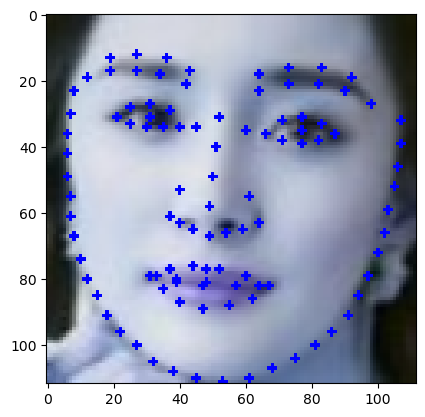

array([[[0.4085205 , 0.9888801 ],
        [0.07206233, 0.21078897],
        [0.11140139, 0.7153553 ],
        [0.13528456, 0.76650345],
        [0.1662297 , 0.813971  ],
        [0.20290732, 0.85764515],
        [0.24281949, 0.9015339 ],
        [0.2869199 , 0.94022894],
        [0.34172526, 0.970457  ],
        [0.06447986, 0.26916793],
        [0.05925507, 0.32570124],
        [0.05822195, 0.38218436],
        [0.05989465, 0.4376026 ],
        [0.06330938, 0.49409387],
        [0.06961577, 0.54968274],
        [0.07800223, 0.6056274 ],
        [0.09224384, 0.6616113 ],
        [0.95826983, 0.28651837],
        [0.8141479 , 0.8159555 ],
        [0.7727829 , 0.8616062 ],
        [0.72398615, 0.9001677 ],
        [0.6707109 , 0.9328287 ],
        [0.6134215 , 0.96068996],
        [0.54924643, 0.9832018 ],
        [0.48124677, 0.99332   ],
        [0.95752084, 0.34974903],
        [0.95065504, 0.41180038],
        [0.9404819 , 0.4726322 ],
        [0.92659086, 0.53171635],
        [0.911

In [15]:
# For the purpose of demonstrating this function, we'll need a path to an image file and a model file
image_path = "./data/samples/1.jpg"
model_path = "./checkpoint/v3/v3.pth"
predict_landmarks(image_path, model_path, backbone="v3")
predict_and_show_landmarks(image_path, model_path,backbone="v3")